Plan :

* Use [species distribution modeling](http://rspatial.org/sdm/) to estimate species ranges for host and phage
    * Geographic overlay for compartmentalized biomes, particularly host-associations?
* Use phylogenomic approach to biogeography to identify phage with interesting recent patterns of movement
* For each host-phage link from the CRISPR data, build a latent space of ecological features :
    * geographic range of host
    * geographic range of phage
    * intersection of host and phage range
    * phage biogeography
    * host biogeography (if we can find more than one strain of the host)
    * phylogenetic diversity of host
    * phylogenetic diversity of phage
    * co-phylogeny graph properties
* Train a model on the latent space
    * Success : Predictive model of new and/or unobserved infection
    * Failure : Explore database limitations, develop recommendations to address them
    


In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import seaborn
import networkx
from grave import grave
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import cartopy.crs
from cartopy.io.img_tiles import OSM
#from geopy.geocoders import Nominatim
#from geopy.distance import geodesic
from scipy.cluster import hierarchy
import screed
#import os
import pyprind

Populating the interactive namespace from numpy and matplotlib


In [2]:
metadata = pandas.read_csv( 'data/Table1_5_combined.txt', sep='\t', 
                      dtype={'Body_site':str, 'POGs_SUBFAMILY':str} )
metadata.head()

,UViG,TAXON_OID,Scaffold_ID,VIRAL_CLUSTERS,Ecosystem,Ecosystem_Category,Ecosystem_Type,Ecosystem_Subtype,Habitat,Body_site,...,Host,Host_detection,Host_domain,Estimated_completeness,Quality,POGs_ORDER,POGs_FAMILY,POGs_SUBFAMILY,POGs_GENUS,putative_retrovirus
0,2003000007_____2003296998,2003000007,2003296998,sg_24096,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
1,2003000007_____2003297061,2003000007,2003297061,sg_24097,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
2,2003000007_____2003297087,2003000007,2003297087,sg_24098,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
3,2003000007_____2003297164,2003000007,2003297164,sg_24099,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
4,2003000007_____2003297262,2003000007,2003297262,sg_24100,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,NaN,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN


In [3]:
metadata.columns

Index(['UViG', 'TAXON_OID', 'Scaffold_ID', 'VIRAL_CLUSTERS', 'Ecosystem',
       'Ecosystem_Category', 'Ecosystem_Type', 'Ecosystem_Subtype', 'Habitat',
       'Body_site', 'perc_VPF', 'Host', 'Host_detection', 'Host_domain',
       'Estimated_completeness', 'Quality', 'POGs_ORDER', 'POGs_FAMILY',
       'POGs_SUBFAMILY', 'POGs_GENUS', 'putative_retrovirus'],
      dtype='object')

The `BlastTab+` output format for LAST has the following fields, delimited by tabs :

0. query id
* subject id
* % identity
* alignment length
* mismatches
* gap opens
* q. start
* q. end
* s. start
* s. end
* evalue
* bit score
* query length
* subject length
* raw score


query_id : 637000024:NC_003228:2:2998261
taxon_id:scaffold_id:annotation_in_scaffold:scaffold_coordinate

subject_id : 7000000526_____SRS019397_WUGC_scaffold_4145
taxon_id_____scaffold_id

In [4]:
lastal_cols = [ 'query_id', 'subject_id', 'identity', 'alignment_length',
                'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start',
                's_end', 'evalue', 'bitscore', 'query_length', 'subject_length',
                'raw_score' ]

df = pandas.read_csv( 'data/spacers_vs_all_viral_sequences_combined_v2_Filtered_1Snp_100AF.lout', 
                      sep='\t', names=lastal_cols, index_col=False )

# merge viral clusters
clusters = metadata[ ['UViG', 'VIRAL_CLUSTERS'] ]
clusters.columns = [ 'subject_id', 'vcluster' ]
df = df.merge( clusters, on='subject_id' )

# merge CRISPR array
df['CRISPR_array'] = [ ':'.join(name.split(':')[:2]) for name in df.query_id ]

print(df.shape)
df.head()

(90108, 17)


,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length,raw_score,vcluster,CRISPR_array
0,637000024:NC_003228:2:2998261,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,637000024:NC_003228
1,637000024:NC_003228:2:2998455,7000000526_____SRS019397_WUGC_scaffold_4145,97.06,34,1,0,1,34,22655,22688,2.500000e-07,52.2,34,47940,32,sg_282454,637000024:NC_003228
2,647533110:NZ_GG705213:1:413342,7000000526_____SRS019397_WUGC_scaffold_4145,96.67,30,1,0,30,1,34447,34476,3.200000e-05,45.9,30,47940,28,sg_282454,647533110:NZ_GG705213
3,650377910:FQ312004:2:4712990,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,30,0,0,1,30,29564,29593,1.800000e-06,49.0,30,47940,30,sg_282454,650377910:FQ312004
4,2571042234:JGEV01000024:2:689262,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,2571042234:JGEV01000024


In [5]:
print( 'viral clusters :', len(set(df.vcluster)) )
print( 'UViGs          :', len(set(metadata.UViG)))

viral clusters : 12253
UViGs          : 746045


In [6]:
#G = networkx.Graph()
#G.add_nodes_from( set( df['query_id'] ) | set( df['subject_id'] ) )
G = networkx.convert_matrix.from_pandas_edgelist( df, 'CRISPR_array', 'vcluster', 'bitscore' )

#G.add_nodes_from( set( ':'.join(name.split(':')[:2]) for name in df.query_id ) )
#G.add_nodes_from( set( df.subject_id ) )

networkx.set_node_attributes( G, { ':'.join(name.split(':')[:2]) : {'type':'CRISPR_array'} for name in df.query_id } )
networkx.set_node_attributes( G, { name : {'type':'vcluster'} for name in df.vcluster } )

#progbar = pyprind.ProgBar( df.shape[0], title='adding graph edges...' )

#for n,row in df.iterrows() :
#    progbar.update()
#    G.add_edge( row['subject_id'], row['query_id'], weight=row['bitscore'] )

In [7]:
# get the adjacency matrix in sparse form
#aj = networkx.to_scipy_sparse_matrix(G)

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

1261


[]

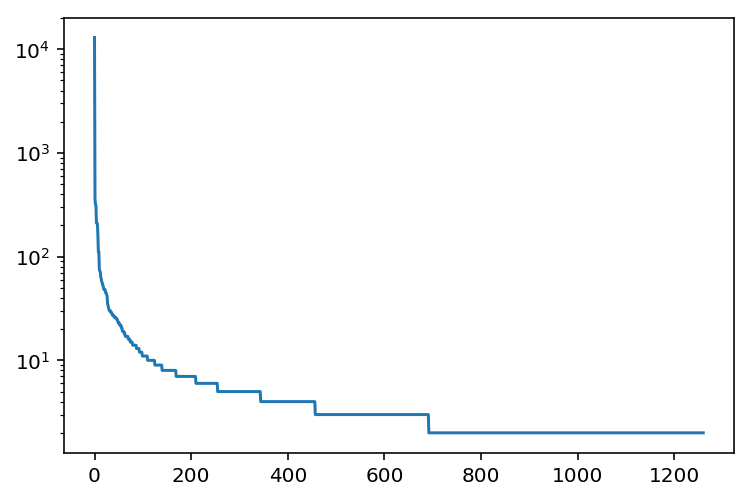

In [8]:
print( len(components) )
plot( list( map( len, components ) ) )
semilogy()

In [9]:
bit_min = min( df['bitscore'] )
bit_max = max( df['bitscore'] )
bit_med = median( df['bitscore'] )

pandas.DataFrame.describe( df['bitscore'] )

count    90108.000000
mean        52.270578
std          4.649566
min         42.700000
25%         49.000000
50%         52.200000
75%         55.300000
max        155.000000
Name: bitscore, dtype: float64

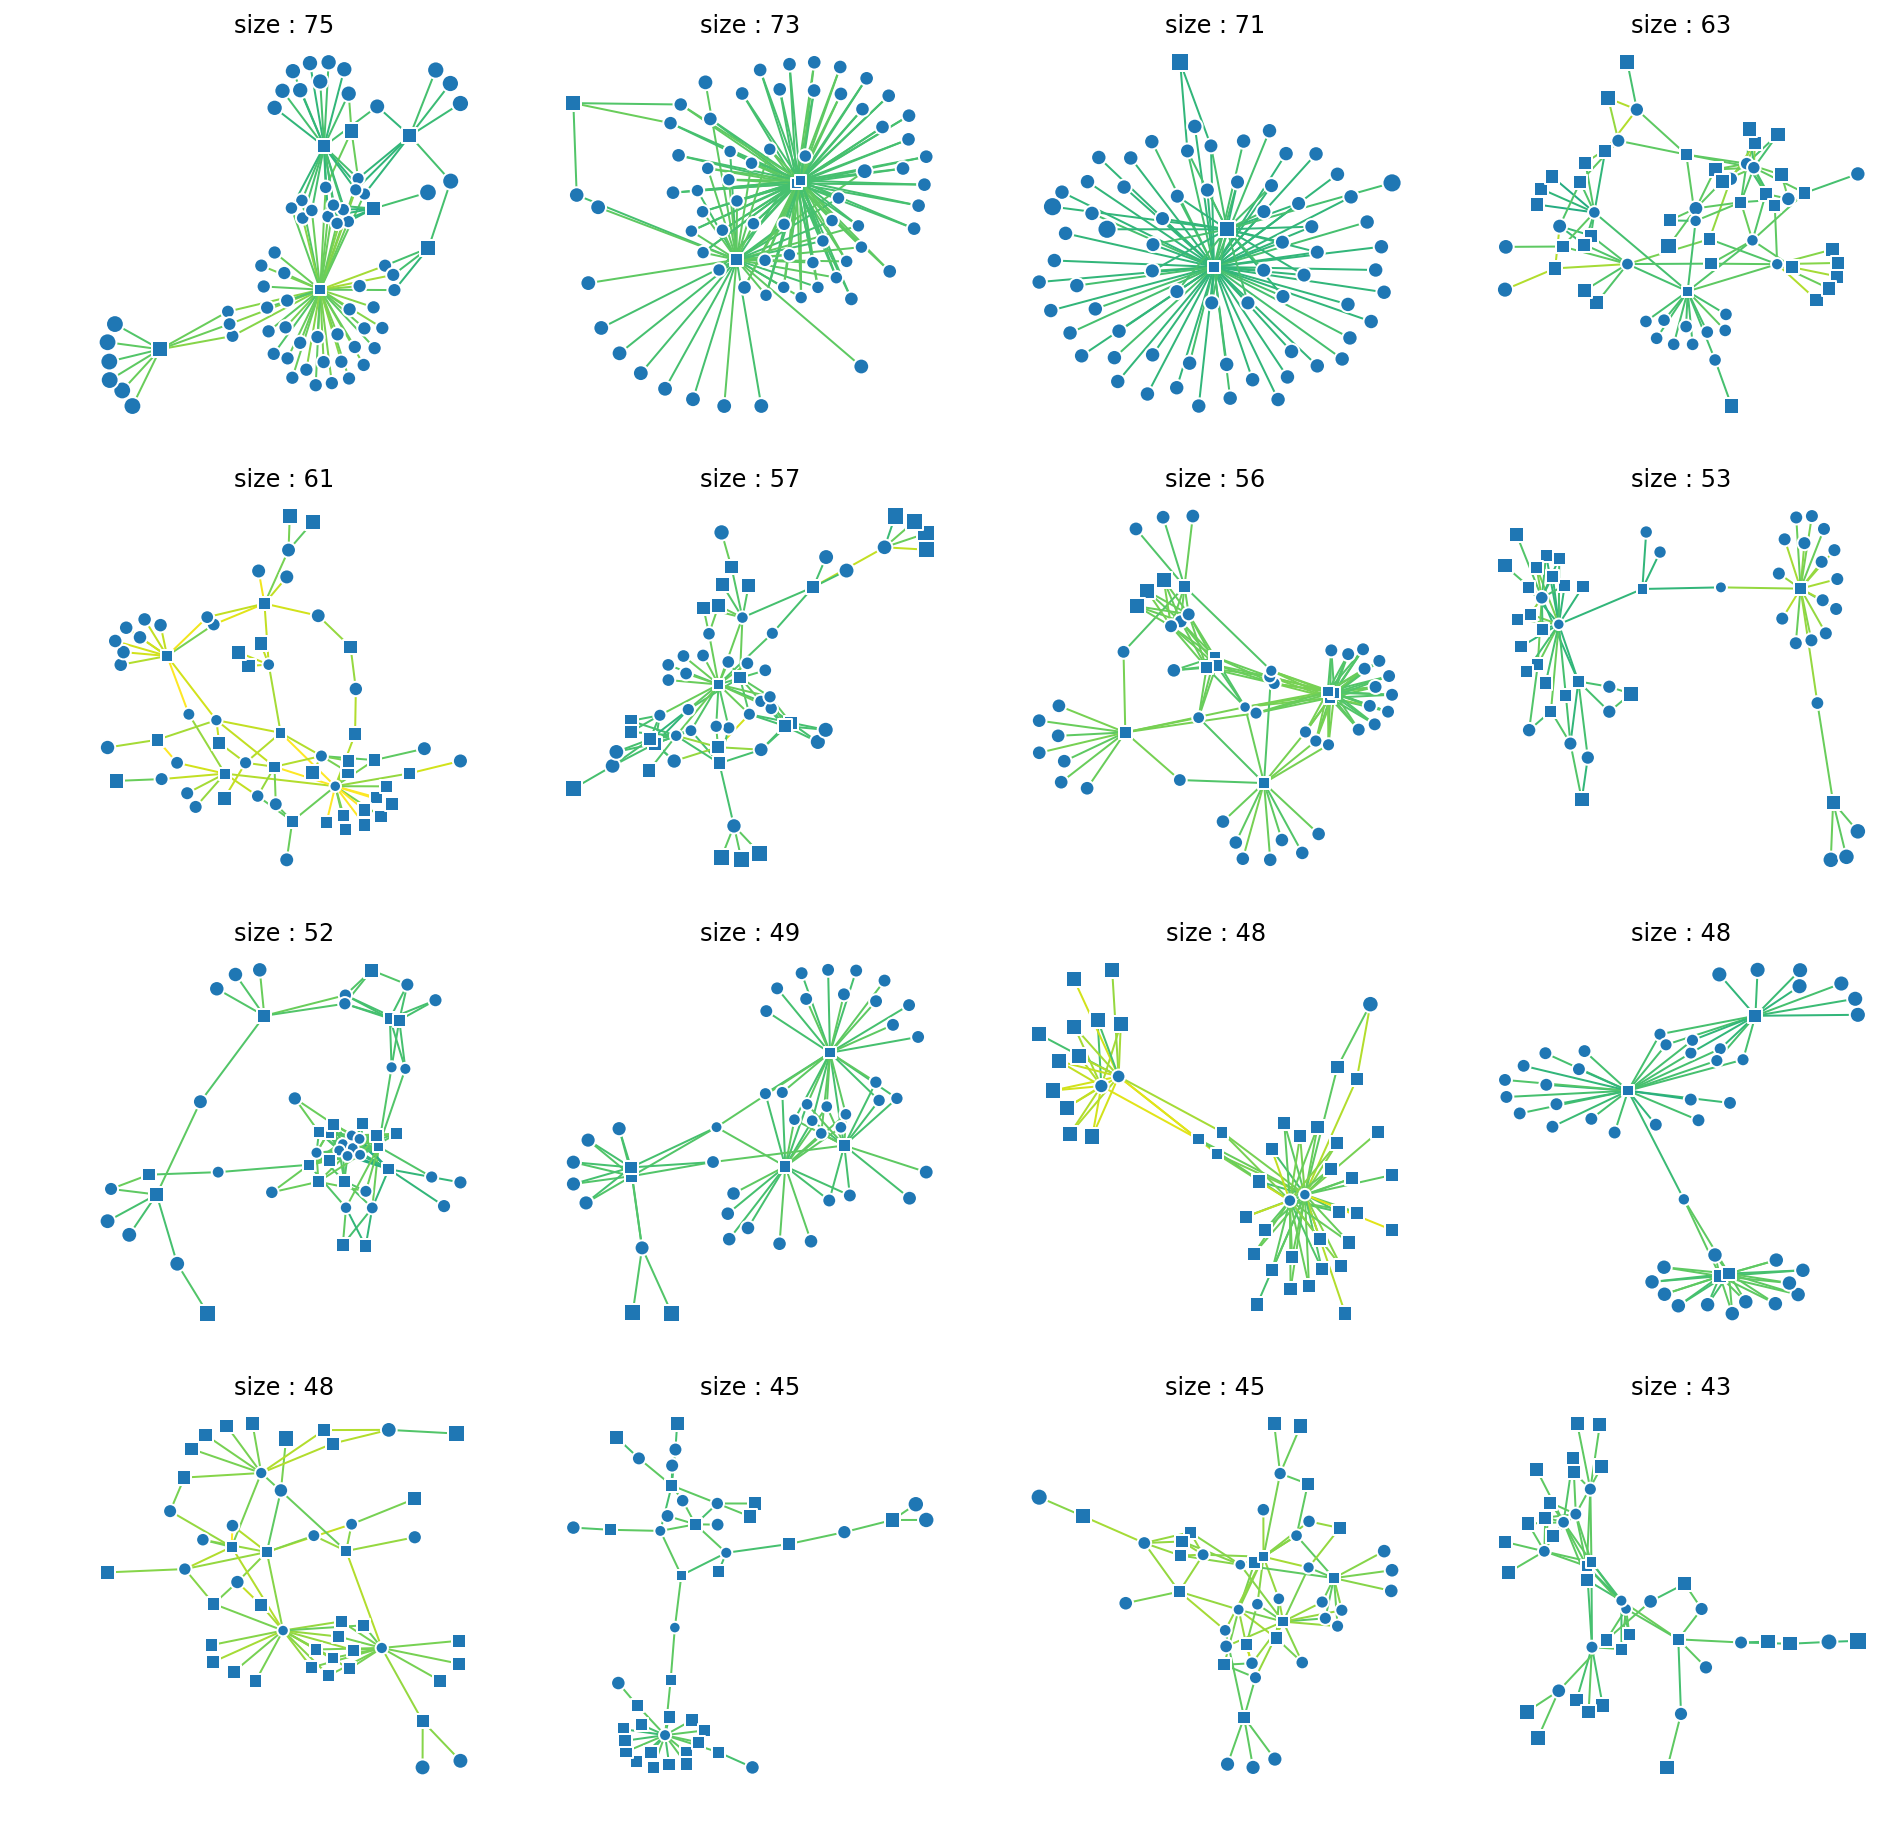

In [10]:
from grave import plot_network, use_attributes

figure( figsize = ( 16, 16 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

for n,g in enumerate(components[ 10:26 ]) :
    subplot( 4, 4, n+1 )
    title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    
    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data():
        node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
        if node_attributes['type'] == 'CRISPR_array' :
            node_attributes['shape'] = 's'
    
    for u, v, edge_attributes in g.edges.data():
        #c = (centrality[u] +
        #     centrality[v]) / 2
        #color_idx = (c / max_centrality)
        color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
        cmap = get_cmap()
        edge_attributes['color'] = cmap(color_idx)
        edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
    plot_network( g, layout='spring',
                  node_style=use_attributes(),
                  edge_style=use_attributes('color') )

In [11]:
metadata.shape

(746045, 21)

In [15]:
from graph_kernels import WL_subtree_kernel

kp = WL_subtree_kernel.compute_mle_wl_kernel( components, 3 )

TypeError: must be str, not Graph

In [16]:
import igraph
import graphkernels.kernels as gk

ig = igraph.Graph()
ig.add_vertices( list( set( df[ 'CRISPR_array' ] ) ) )
n = len(ig.vs)
ig.add_vertices( list( set( df[ 'vcluster' ] ) ) )
ig.vs[ 'label' ] = [ 0 ] * n + [ 1 ] * ( len(ig.vs) - n )
ig.add_edges( [ ( row.CRISPR_array, row.vcluster ) for n,row in df[ ['CRISPR_array',
                                                                     'vcluster' ] ].iterrows() ] )
ig.es[ 'weight' ] = list( df[ 'bitscore' ] )

igc = ig.components().subgraphs()

In [ ]:
#%%debug
#import pdb
#from pdb import set_trace as bp

kp = gk.CalculateWLKernel( igc[10:] )
#seaborn.clustermap( wlkp, mask=numpy.isnan(kp) )

#kp = gk.CalculateConnectedGraphletKernel( igc[1:162] )
#seaborn.clustermap( kp )

#kp = gk.CalculateExponentialRandomWalkKernel( igc[ 10: ] )

seaborn.clustermap( kp )

In [191]:
len(igc0.vs)

12983

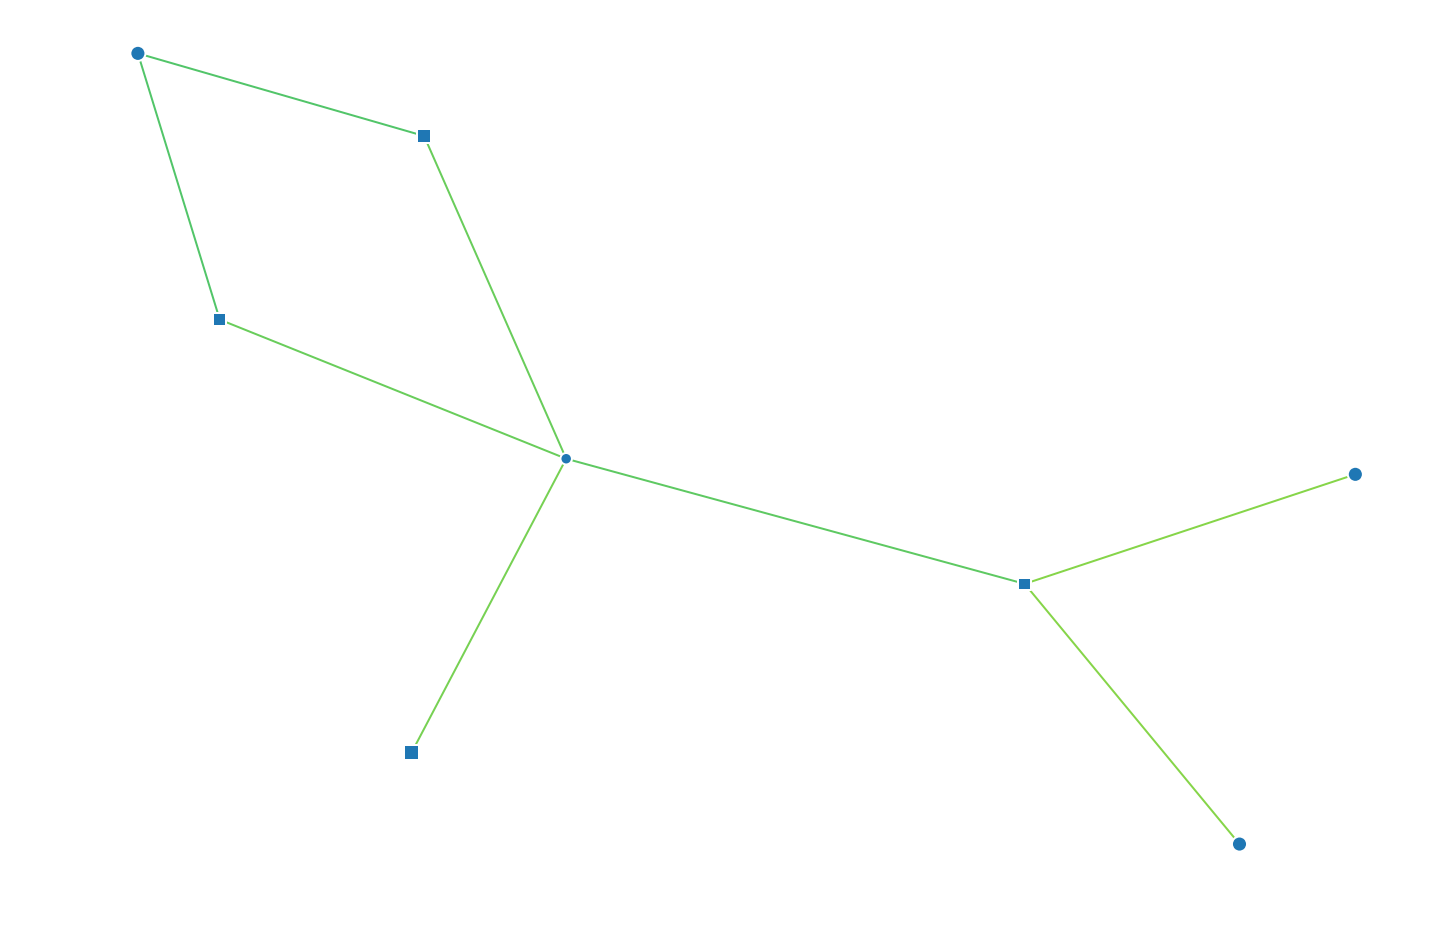

In [41]:
from grave import plot_network, use_attributes

figure( figsize = ( 12, 8 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

g = components[ 162 ]
    
centrality = networkx.closeness_centrality( g )
max_centrality = max( centrality.values() )
    
for node, node_attributes in g.nodes.data():
    node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
    if node_attributes['type'] == 'CRISPR_array' :
        node_attributes['shape'] = 's'

for u, v, edge_attributes in g.edges.data():
    color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
    cmap = get_cmap()
    edge_attributes['color'] = cmap(color_idx)
    edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
plot_network( g, layout='spring',
              node_style=use_attributes(),
              edge_style=use_attributes('color') )

In [11]:
import sqlite3
import os.path
from dna_features_viewer import GraphicFeature, GraphicRecord


NERSC_prefix = '/global/dna/projectdirs/microbial/img_web_data_merfs/'

def get_scaffold_stats( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'scaffold_stats.sdb' )
    if os.path.exists( scaffdb_path ) :
        conn = sqlite3.connect( scaffdb_path )
        scaff_df = pandas.read_sql_query( 'select * from scaffold_stats where scaffold_oid=:oid;', 
                                          conn, params={'oid':scaffold} )

        return scaff_df
    else :
        raise Exception( 'Could not find scaffold {} for taxon {}'.format( scaffold, taxon ) )

def get_crispr_stats( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'crispr.sdb' )
    if os.path.exists( scaffdb_path ) :
        conn = sqlite3.connect( scaffdb_path )
        scaff_df = pandas.read_sql_query( 'select * from taxon_crispr_details;', 
                                          conn, params={'oid':scaffold} )

        return scaff_df
    else :
        raise Exception( 'Could not find scaffold {} for taxon {}'.format( scaffold, taxon ) )
        
def get_scaffold_genes( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'scaffold_genes' )
    if os.path.exists( scaffdb_path ) :
        for dbfile in os.listdir( scaffdb_path ) :
            conn = sqlite3.connect( os.path.join( scaffdb_path, dbfile ) )
            
            scaff_df = pandas.read_sql_query( 'select * from scaffold_genes where scaffold_oid=:oid;', 
                                              conn, params={'oid':scaffold} )
            
            scaff_df['gene'] = [ '_____'.join( map( str, [ taxon, 
                                                           row.scaffold_oid,
                                                           row.gene_oid ] ) ) 
                                 for n,row in scaff_df.iterrows() ]
                        
            if scaff_df.shape[0] :
                return scaff_df    

In [15]:
#taxon_table = pandas.read_csv( '../imgdb/img_taxon_table.csv', index_col=0 )
#env_table   = pandas.read_csv( '../imgdb/img_env_sample_table.csv', index_col=0 )
taxon_latlon = pandas.read_csv( '../imgdb/taxon_latlon.csv', index_col=0 )

In [16]:
taxon_latlon.dropna().head()

,TAXON_OID,LATITUDE,LONGITUDE,GOLD_ID,ANALYSIS_PROJECT_TYPE
5,637000271,58.42198,-149.574839,Gp0000347,Genome Analysis
10,2523533631,29.82,-95.34,Gp0000353,Genome Analysis
11,637000295,40.75,-73.98,Gp0000354,Genome Analysis
13,637000029,33.94,-117.4,Gp0000356,Genome Analysis
16,2524023073,35.080371,-106.627085,Gp0000166,Genome Analysis


In [17]:
d = metadata.merge( taxon_latlon, on='TAXON_OID' )
locations = set()
for n,item in d[ ['LATITUDE', 'LONGITUDE'] ].dropna().iterrows() :
    locations.add( tuple( map( float, item ) ) )

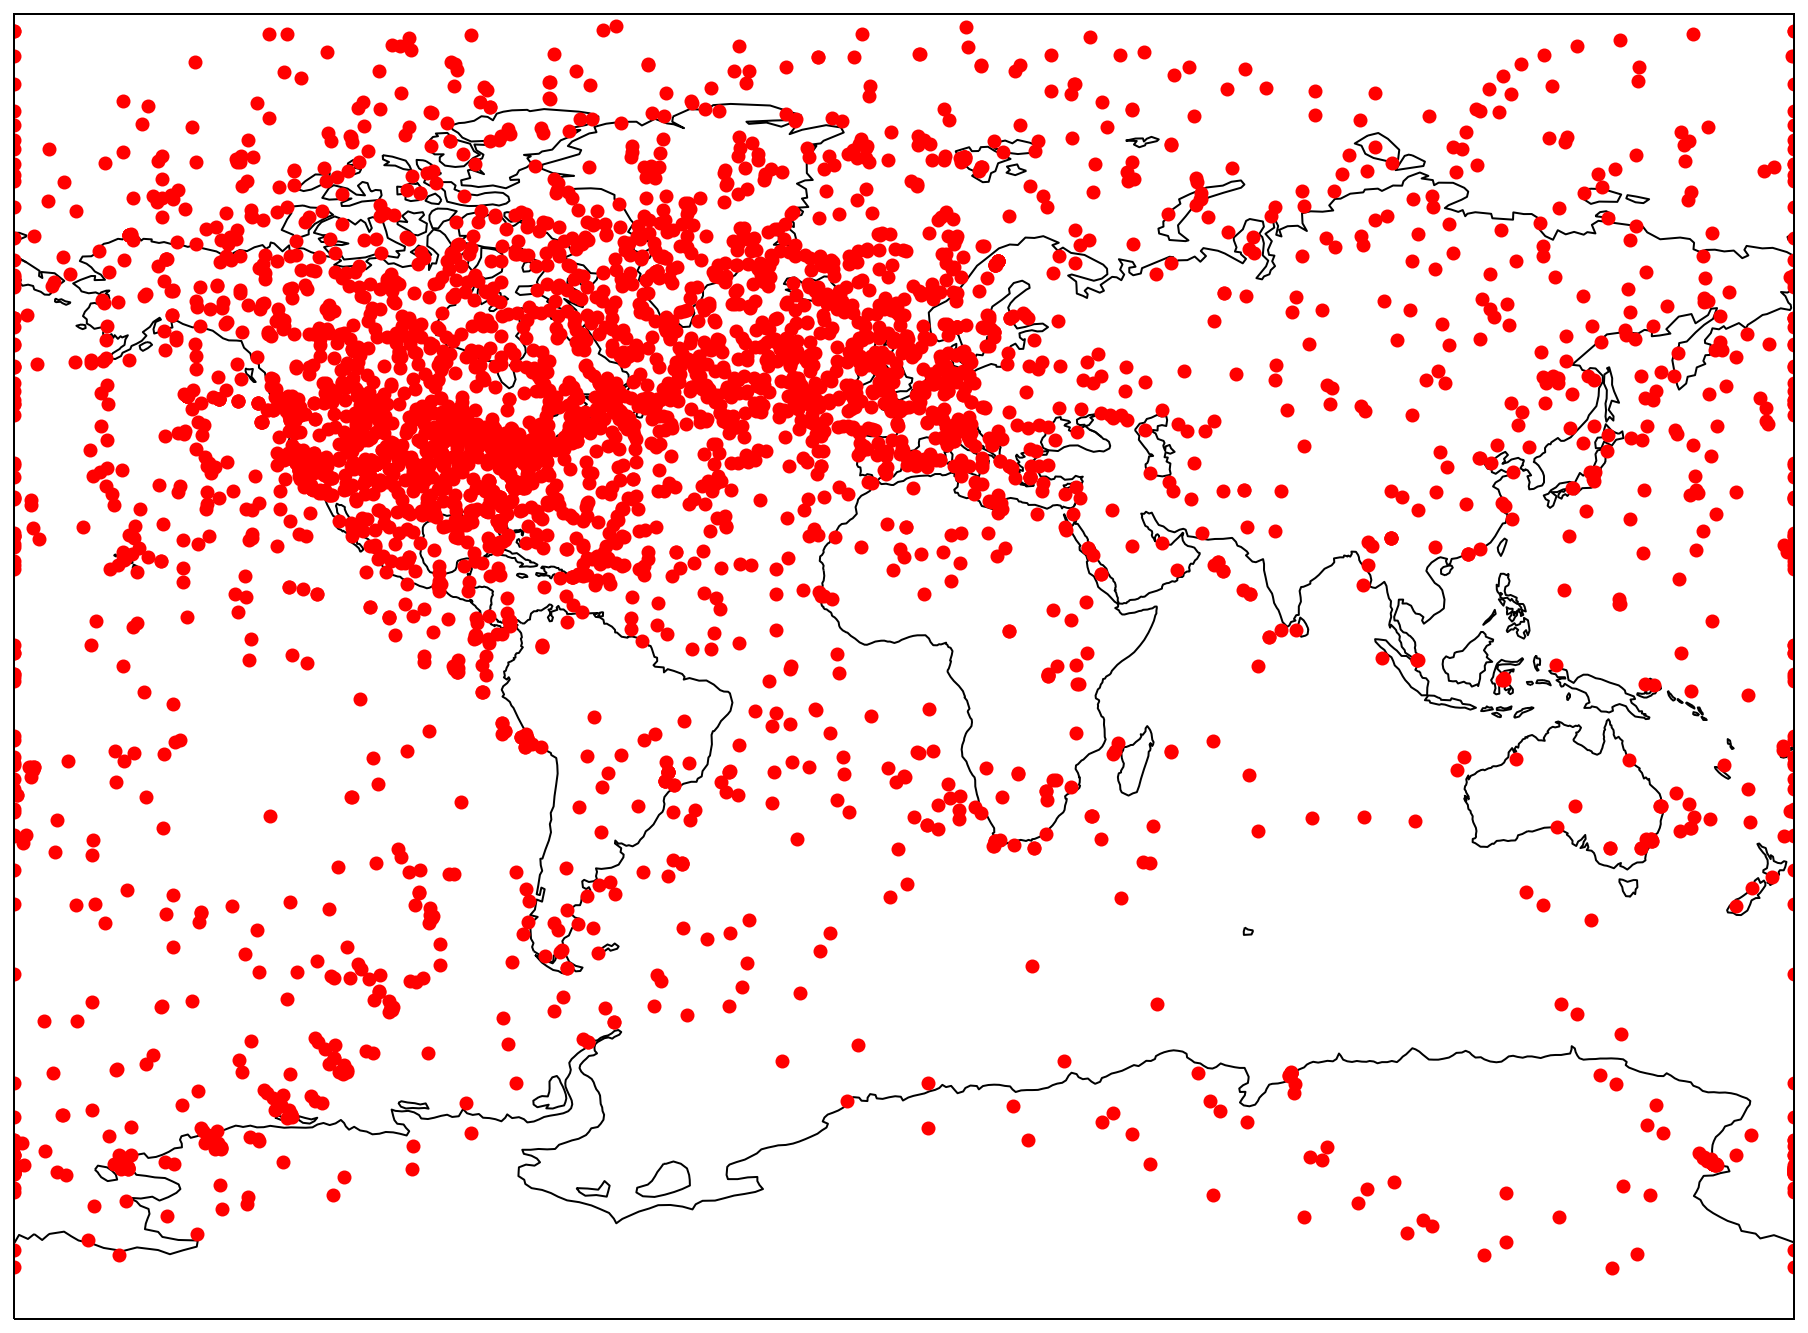

In [19]:
figure( figsize=(18,12) )

ax = plt.axes( projection=cartopy.crs.Miller() )
#ax.add_image( GoogleTiles( style='satellite' ), 3 )
ax.coastlines()

y, x = zip(*locations)
plot( x, y, 'ro', transform=cartopy.crs.Geodetic() )

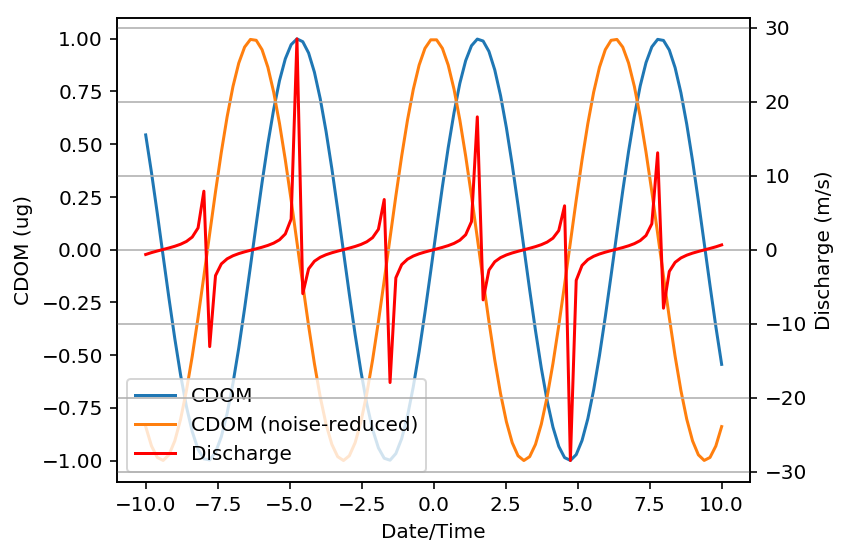

In [100]:
fig, ax1=plt.subplots()
ax1.set_xlabel('Date/Time')
ax1.set_ylabel('CDOM (ug)')

date_time = linspace( -10, 10, 100 )
cdom = sin(date_time)
filtcdom = cos(date_time)
discharge = tan(date_time)

lns1=ax1.plot(date_time,cdom, label='CDOM')
lns2=ax1.plot(date_time,filtcdom, label='CDOM (noise-reduced)')
ax2=ax1.twinx()
color='red'
ax2.set_ylabel('Discharge (m/s)')
lns3=ax2.plot(date_time,discharge,color=color, label='Discharge')
fig.tight_layout()
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=3)
plt.grid( axis='y' )

In [95]:
plt.grid?